Simulation converged at step: 10


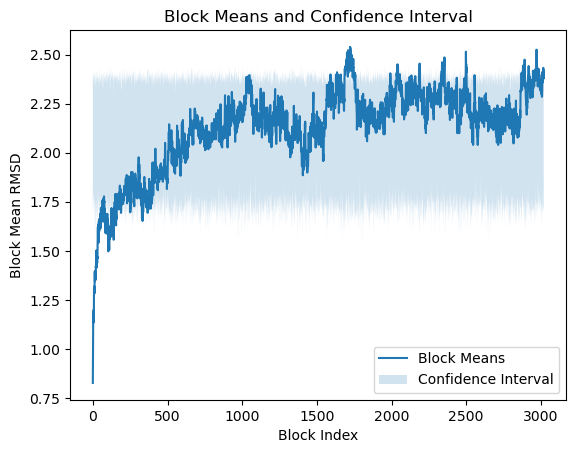

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def block_bootstrap(data, block_size):
    """
    Performs block bootstrap on a given data array.

    Args:
        data (np.ndarray): The data array.
        block_size (int): The size of blocks for resampling.

    Returns:
        np.ndarray: A 2D array of bootstrapped samples.
    """
    n_samples = len(data)
    n_blocks = n_samples // block_size

    bootstrapped_data = np.empty((n_blocks, block_size))
    for i in range(n_blocks):
        # Sample starting index for a block
        start_index = np.random.randint(0, n_samples - block_size + 1)
        bootstrapped_data[i] = data[start_index:start_index + block_size]

    return bootstrapped_data

def read_rmsd_data(filename):
    """
    Reads RMSD data from a file.

    Args:
        filename (str): Path to the file containing RMSD data.

    Returns:
        np.ndarray: Array of RMSD values.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()

    # Assuming each line contains a single RMSD value
    rmsd_data = [float(line.strip()) for line in lines if line.strip()]
    return np.array(rmsd_data)  # Convert to NumPy array

def block_bootstrap_convergence(rmsd_data, block_size=10, n_bootstraps=100, alpha=0.05):
    """
    Analyzes convergence of MD simulation using block bootstrap.

    Args:
        rmsd_data (np.ndarray): Array of RMSD values for each simulation step.
        block_size (int, optional): Size of blocks for bootstrapping. Defaults to 10.
        n_bootstraps (int, optional): Number of bootstrap replicates. Defaults to 100.
        alpha (float, optional): Significance level for convergence check. Defaults to 0.05.

    Returns:
        tuple: (bool, float, np.ndarray) - Whether converged (True), equilibration time (int), block means of original data
    """
    # Check if data length is a multiple of block size
    if len(rmsd_data) % block_size != 0:
        raise ValueError("Data length must be a multiple of block size for block bootstrap")

    # Perform block bootstrap
    bootstrapped_means = np.empty((n_bootstraps, len(rmsd_data) // block_size))
    for i in range(n_bootstraps):
        bootstrapped_data = block_bootstrap(rmsd_data, block_size=block_size)
        bootstrapped_means[i] = np.mean(bootstrapped_data, axis=1)

    # Calculate original block means for comparison
    original_blocks = np.split(rmsd_data, len(rmsd_data) // block_size)
    block_means = np.mean(original_blocks, axis=1)

    # Identify convergence point (assuming increasing trend in block means)
    converged = False
    equilibration_time = 0
    for i in range(1, len(block_means)):
        # Check if all block means before i are below the lower confidence bound
        if np.all(block_means[:i] < np.percentile(bootstrapped_means[:, i - 1], alpha * 100)):
            converged = True
            equilibration_time = i * block_size
            break

    return converged, equilibration_time, block_means, bootstrapped_means

# Example usage
filename = "C:/Users/IPA02/Documents/sequence_model/RMSD_a/rmsd.dat"  # Replace with your actual filename
rmsd_data = read_rmsd_data(filename)

converged, equilibration_time, block_means, bootstrapped_means = block_bootstrap_convergence(rmsd_data)

if converged:
    print("Simulation converged at step:", equilibration_time)
else:
    print("Simulation might not be converged yet.")

# Optional plotting (modified to plot block means and confidence intervals)
plt.plot(block_means, label="Block Means")
alpha = 0.05  # Make sure alpha is defined
percentiles = np.percentile(bootstrapped_means, [alpha * 100, (1 - alpha) * 100], axis=0)

# Shade the confidence interval area
plt.fill_between(range(len(block_means)), percentiles[0], percentiles[1], alpha=0.2, label="Confidence Interval")
plt.legend()
plt.xlabel("Block Index")
plt.ylabel("Block Mean RMSD")
plt.title("Block Means and Confidence Interval")
plt.show()
